# **Project: Remaining Useful Life Prediction**

##  Task: RUL Prediction using CNN model

This project focuses on developing a 1D Convolutional Neural Network (CNN) to predict the Remaining Useful Life (RUL) of jet engines. The model is trained on sensor data from the NASA Turbofan Engine Degradation Simulation Dataset, using a sliding window approach to capture local dependencies.

### Data: 

To effectively model the patterns of engine degradation, a sliding window approach with a window size of (30, 14) has been applied. This ensures that each training sample includes 30 consecutive time steps with 14 sensor features per step, enabling the model to learn degradation trends over time.

- X_train data shape:  (14184, 30, 14)
- y_train data shape:  (14184,)
- X_val data shape:  (3547, 30, 14)
- y_val data shape:  (3547,)
- X_test data shape:  (100, 30, 14)
- y_test data shape:  (100,)

### Model Architecture: 1D CNN for Time-Series Regression

Design and train a 1D CNN model for time-series regression.

input data shape: (14104, 30, 14) (sample, time steps, features)
  - 14104 sample size
  - each sample: 30 time steps with 14 features at each step

1D CNN applies convolution fliters along the time dimension, detecting **local dependencies**. Instead of looking at spatial features (as in images), 1D CNNs detect trends, changes, and dependencies in time-series signals.

### Result:
- MAE: 11.59
- RMSE: 15.43
- Score: 474.34

Score function for prognostics:

The function penalizes late predictions more than early ones, which is crucial for Remaining Useful Life (RUL) prediction.


In [1]:
__author__ = "Bing Huang"
__email__ = "Binghuang1990@gmail.com"

# **0. Load Dependencies**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf


# Set all possible seeds
seed = 42
tf.random.set_seed(seed)


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, BatchNormalization, Flatten, Dense, Dropout

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping,  ReduceLROnPlateau

# **1. Load Data** 

In [3]:
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_val = np.load("X_val.npy")
y_val = np.load("y_val.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

In [4]:
print("X_train data shape: ", X_train.shape)
print("y_train data shape: ", y_train.shape)
print("X_val data shape: ", X_val.shape)
print("y_val data shape: ", y_val.shape)
print("X_test data shape: ", X_test.shape)
print("y_test data shape: ", y_test.shape)

X_train data shape:  (14184, 30, 14)
y_train data shape:  (14184,)
X_val data shape:  (3547, 30, 14)
y_val data shape:  (3547,)
X_test data shape:  (100, 30, 14)
y_test data shape:  (100,)


# **2. Build and Train 1D CNN model**

In [5]:
input_shape = (X_train.shape[1], X_train.shape[2])  # （30， 14）
#----------------
# Create a CNN model
#------------------
model = Sequential()
#----------------
# Add 3 1D convolutional layers with kernel size 7
#------------------
model.add(Conv1D(64, kernel_size=7, activation='relu', input_shape=input_shape, padding='same'))    # 256 kernels,  each filter applies a 1D convolution over 7 time steps
model.add(Conv1D(64, kernel_size=7, activation='relu', padding='same'))
model.add(Conv1D(64, kernel_size=7, activation='relu', padding='same'))
#----------------
# Add full connected layers
model.add(GlobalAveragePooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            6336      
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 64)            28736     
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 64)            28736     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                        

In [6]:
# Model compilation 模型编译 using the Adam optimizer
optimizers_adam = Adam(learning_rate = 0.001)

model.compile(
    optimizer=optimizers_adam , 
    loss='mse',  # Loss function
    metrics=['mae']  # Evaluation metric
)



In [7]:
# Train the model with early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',      # Metric to monitor (validation loss)
    patience=10,             # Number of epochs with no improvement in val_loss before stopping
    restore_best_weights=True  # Restore model weights from the best epoch
)


history = model.fit(X_train, 
            y_train, 
            epochs=100,
            batch_size=32, 
            validation_data=(X_val, y_val), 
            verbose=1,
            callbacks=[early_stopping])

Epoch 1/100
444/444 [==============================] - 3s 3ms/step - loss: 833.0015 - mae: 21.1479 - val_loss: 497.4952 - val_mae: 17.2541
Epoch 2/100
444/444 [==============================] - 1s 2ms/step - loss: 453.6564 - mae: 16.5417 - val_loss: 403.8455 - val_mae: 16.3353
Epoch 3/100
444/444 [==============================] - 1s 2ms/step - loss: 363.9268 - mae: 14.6640 - val_loss: 295.4277 - val_mae: 13.8261
Epoch 4/100
444/444 [==============================] - 1s 2ms/step - loss: 295.0112 - mae: 13.1407 - val_loss: 339.0114 - val_mae: 15.0268
Epoch 5/100
444/444 [==============================] - 1s 2ms/step - loss: 279.1403 - mae: 12.7184 - val_loss: 254.9129 - val_mae: 12.5072
Epoch 6/100
444/444 [==============================] - 1s 3ms/step - loss: 265.2729 - mae: 12.3418 - val_loss: 249.6803 - val_mae: 12.2111
Epoch 7/100
444/444 [==============================] - 1s 3ms/step - loss: 258.9512 - mae: 12.0859 - val_loss: 297.5807 - val_mae: 13.4412
Epoch 8/100
444/444 [======

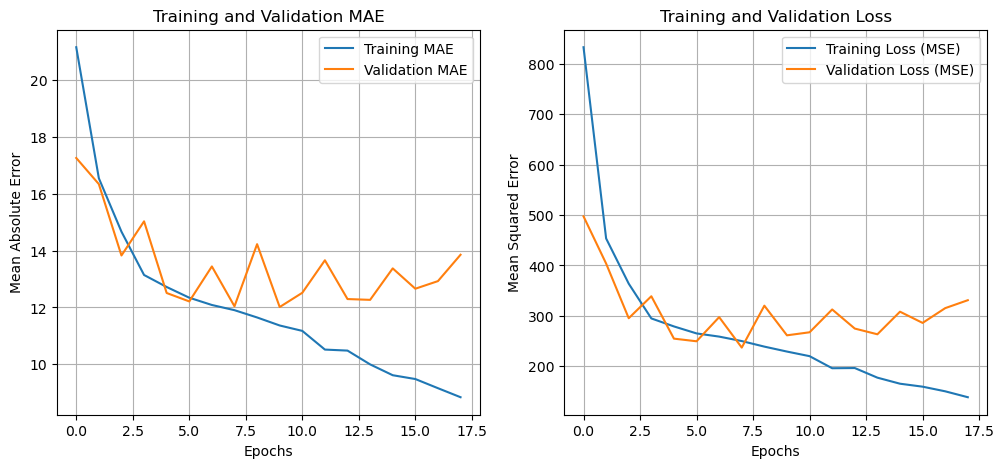

In [8]:
mae = history.history['mae']
val_mae = history.history['val_mae']

loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.legend()
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation MAE')

# Plot MSE
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss (MSE)')
plt.plot(val_loss, label='Validation Loss (MSE)')
plt.legend()
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.grid()
plt.title('Training and Validation Loss')

plt.show()

# **3. Model Prediction and Evaluation**

In [9]:
model.predict(X_test).reshape(-1)

4/4 [==============================] - 0s 3ms/step


array([117.23278  , 115.13029  ,  57.228603 ,  81.7146   , 107.74048  ,
       106.74708  , 100.98715  , 102.996956 , 126.08089  ,  82.7203   ,
        81.93037  ,  97.92608  ,  92.70071  ,  97.79433  , 106.46622  ,
       103.46238  ,  52.063553 ,  31.670195 , 102.46363  ,  23.207838 ,
        92.382774 , 121.019714 , 119.9552   ,  17.260065 , 127.7426   ,
       113.3232   , 101.11239  , 114.43554  ,  88.79839  , 104.9535   ,
        12.501585 ,  53.33376  , 113.66897  ,   6.8922706,  15.601375 ,
        25.218395 ,  32.45511  ,  64.06792  , 121.78291  ,  44.05832  ,
        16.491037 ,   9.152816 ,  66.757034 , 101.96044  ,  74.2857   ,
        41.18296  , 123.98279  , 105.97165  ,  22.266287 , 106.326706 ,
       112.92492  ,  40.120647 ,  40.459743 , 113.77569  , 108.09413  ,
        23.029247 , 100.91895  ,  70.39344  , 106.84893  , 103.44895  ,
        23.919968 ,  42.72753  ,  75.84395  ,  32.691475 , 117.44123  ,
        29.445234 , 120.3193   ,  10.867414 , 117.26461  ,  90.2

In [10]:
y_test

array([112,  98,  69,  82,  91,  93,  91,  95, 111,  96,  97, 124,  95,
       107,  83,  84,  50,  28,  87,  16,  57, 111, 113,  20, 145, 119,
        66,  97,  90, 115,   8,  48, 106,   7,  11,  19,  21,  50, 142,
        28,  18,  10,  59, 109, 114,  47, 135,  92,  21,  79, 114,  29,
        26,  97, 137,  15, 103,  37, 114, 100,  21,  54,  72,  28, 128,
        14,  77,   8, 121,  94, 118,  50, 131, 126, 113,  10,  34, 107,
        63,  90,   8,   9, 137,  58, 118,  89, 116, 115, 136,  28,  38,
        20,  85,  55, 128, 137,  82,  59, 117,  20], dtype=int64)

In [11]:
# model prediction and model preformance

# Predict RUL using the trained model
y_pred = model.predict(X_test).reshape(-1)  # convert it’s a 1D array

y_test = np.clip(y_test, a_min=0, a_max=125)  
y_pred = np.clip(y_pred, a_min=0, a_max=125)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f}")
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae:.2f}")



4/4 [==============================] - 0s 1000us/step
RMSE: 15.43
MAE: 11.59


In [12]:
# score function is 
def score_function(y_true, y_pred):
    """
    Computes the prognostics-specific score function.
    Penalizes late predictions more than early ones.
    """
    error = y_pred - y_true  
    score = np.where(error < 0, np.exp(-error / 13) - 1, np.exp(error / 10) - 1)
    return np.sum(score)

score = score_function(y_test, y_pred)
print(f"score: {score:.2f}")

score: 474.34


In [13]:
# save the model
model.save("CNN_trained_model.h5")  # Save in HDF5 format


# **4. Visualization Model Performance**

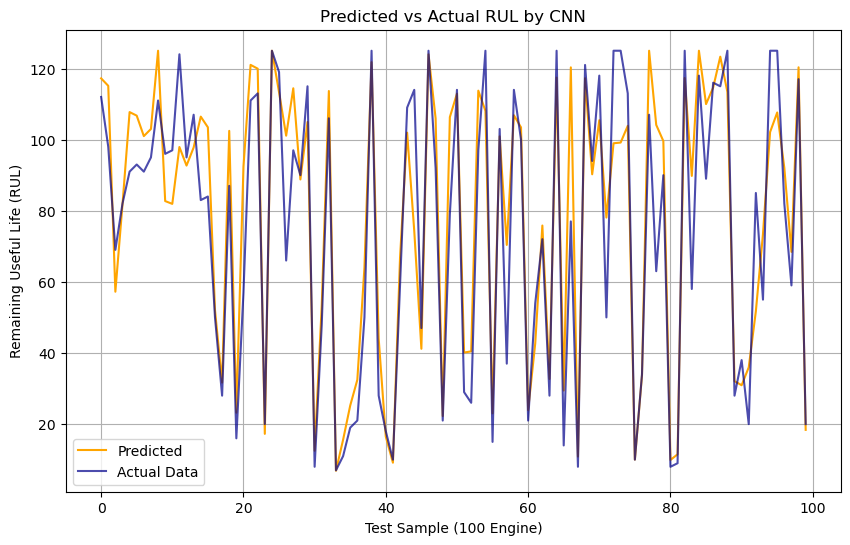

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="orange", alpha=1)
plt.plot(range(len(y_test)), y_test, label="Actual Data", color="darkblue", alpha=0.7)
plt.xlabel("Test Sample (100 Engine)")
plt.ylabel("Remaining Useful Life (RUL)")
plt.title("Predicted vs Actual RUL by CNN")

plt.legend()
plt.grid()
plt.show()

C:\Users\bingh\AppData\Local\Temp\ipykernel_44180\4111974829.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=x_indices, y=errors, palette=bar_colors)


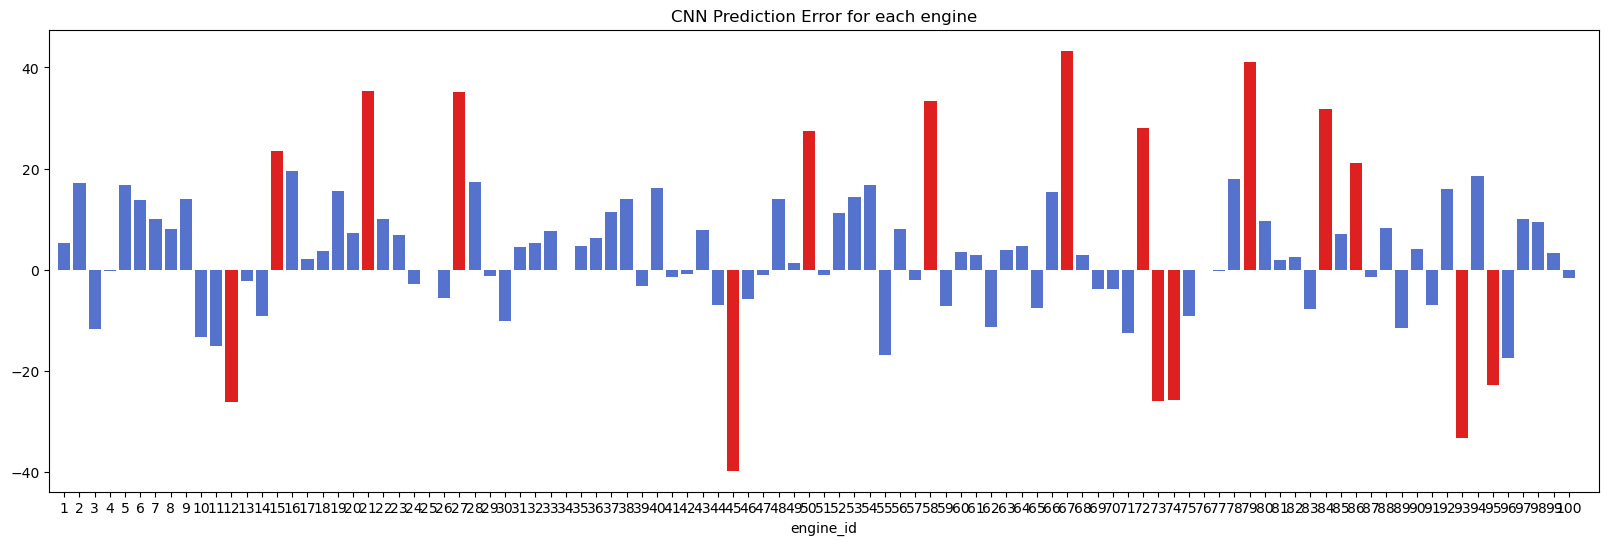

In [33]:
# plot the prediction errors

errors = y_pred - y_test
bar_colors = ['red' if abs(error) > 20 else "royalblue" for error in errors]
# Create an index for x-axis (1 to 100)
x_indices = np.arange(1, len(errors) + 1)

plt.figure(figsize=(20, 6))
sns.barplot(x=x_indices, y=errors, palette=bar_colors)
plt.xlim(-1, 101)
plt.xlabel("engine_id")
plt.title("CNN Prediction Error for each engine")

plt.show()